# Transfer learning: Feature extraction
This code is a adapted from https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/




# Feature extraction

Feature extraction is a process in machine learning and data analysis where relevant information or features are selected or extracted from raw data. The goal of feature extraction is to reduce the dimensionality of the data while retaining the most important and discriminative aspects of the data. This can lead to improved model performance, faster training, and a better understanding of the underlying patterns in the data.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

# Import Data

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"agustntapia","key":"18d1234e910652fd7939e48679c1cd63"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d moltean/fruits

100% 1.28G/1.28G [00:12<00:00, 52.6MB/s]
100% 1.28G/1.28G [00:12<00:00, 113MB/s] 


In [7]:

!unzip -q fruits.zip -d data/

# Data agumentation and pre-processing using tensorflow

For data augmentation, horizontal flip argument is used for data augmentation, we set the image shape and the training, testing and validation sets.


In [9]:

IMAGE_SHAPE = (150, 150)
BATCH_SIZE = 32

train_dir = "data/fruits-360-original-size/fruits-360-original-size/Training"
validation_dir = "data/fruits-360-original-size/fruits-360-original-size/Validation"
test_dir = "data/fruits-360-original-size/fruits-360-original-size/Test"
datagen = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip = True,
                                    validation_split=0.5)

print("Training images:")
train_data = datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Validation images:")
validation_data = datagen.flow_from_directory(validation_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

print("Test images:")
testing_data = datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 6231 images belonging to 24 classes.
Validation images:
Found 3114 images belonging to 24 classes.
Test images:
Found 3110 images belonging to 24 classes.


In [10]:
x,y = next(train_data)
x.shape

(32, 150, 150, 3)

# Example of images

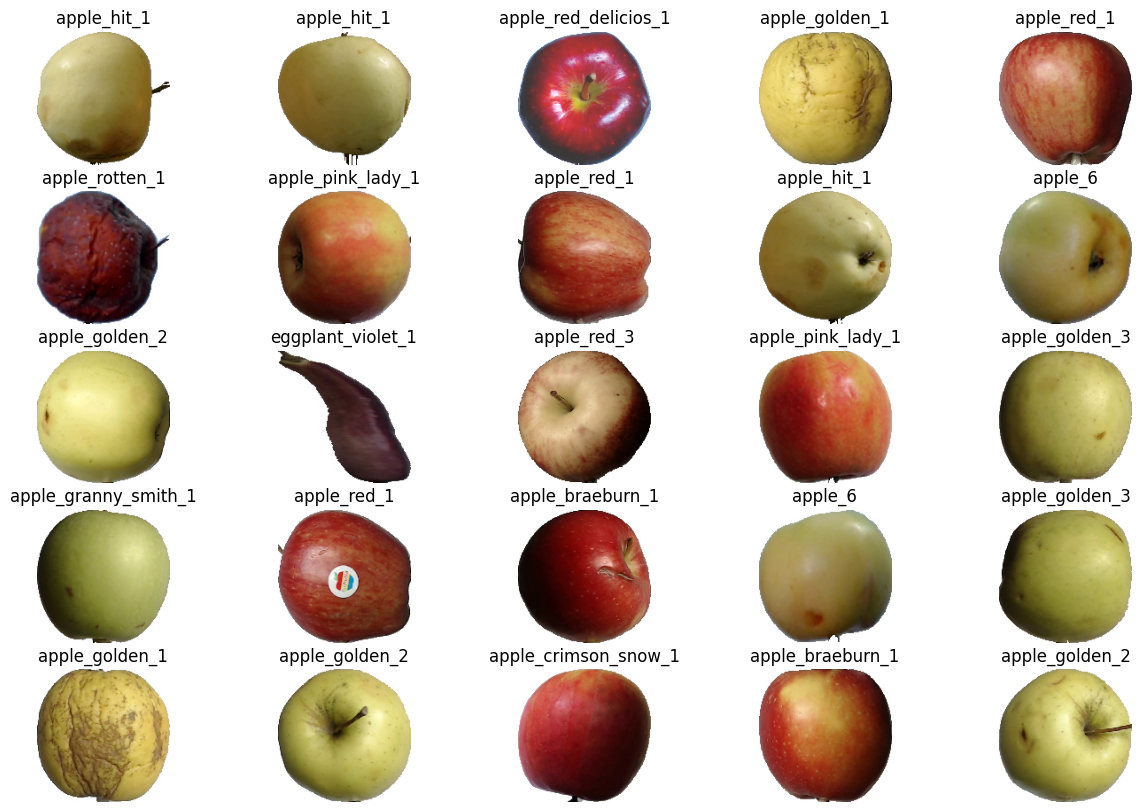

In [11]:
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# Building the Model
## Define the base mdel
The Inception ResNET v2 is a convolutional neural network (CNN) architecture. It is a deep learning architecture developed by Google, which is an evolution of the original Inception architecture (InceptionV1) and is also known as GoogLeNet. InceptionV2 was introduced to improve the efficiency and performance of deep neural networks for computer vision tasks.

For freezing the layer we make use of layer.trainable = False, that means that its internal state will not change during training, model's trainable weights will not be updated during fit(), and also its state updates will not run.



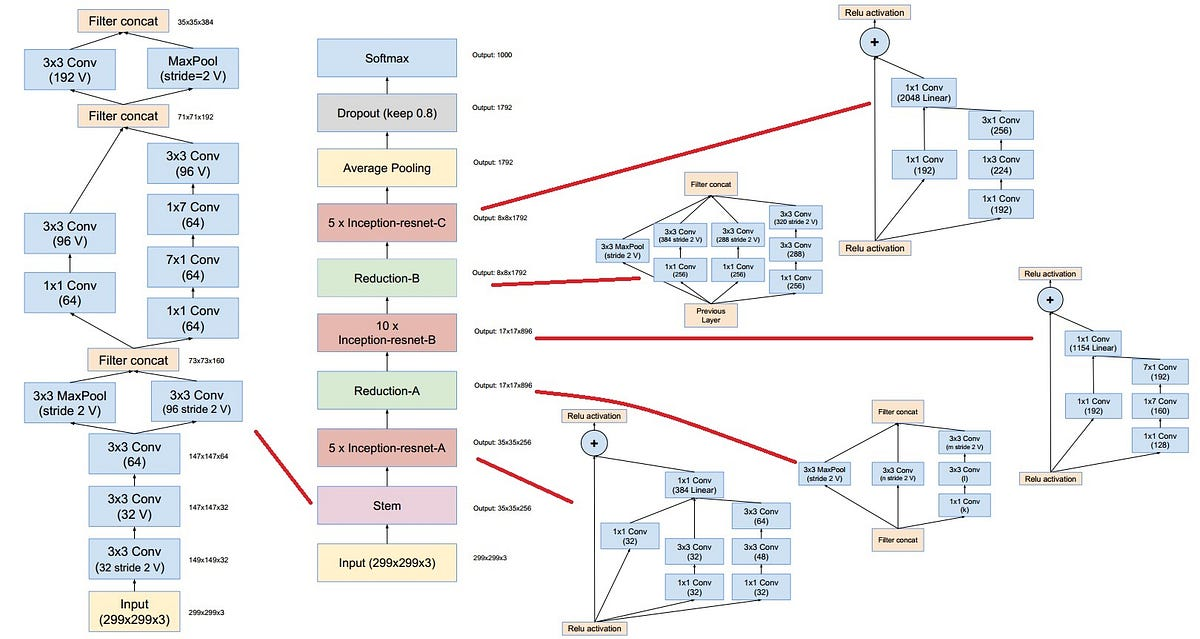

In [13]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )

base_model.trainable=False

## Create our own model

Our model has the base model, a add **Batch normalization** layer is used because it is a normalization technique which is done along mini-batches instead of the full data set. It is used to speed up training and use higher learning rates.
It maintains the mean output close to 0 and the output standard deviation close to 1.
**GlobalAveragePooling2D** It computes the average value of each input channel across the entire image, reducing the image dimensionality and producing a 1D tensor. It's a 2D global average pooling operation where depth equals the number of filters.
**Dropout** is also used whose function is to randomly drop some neurons from the input unit so as to prevent overfitting. The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped.  A Fully Connected (FC) layer is a type of layer where each neuron or unit is connected to every neuron in the previous layer. In a Fully Connected layer, there are **Dense** connections between neurons, which means that every output from the previous layer is used as input for each neuron in the Fully Connected layer. These layers are regular fully connected neural network layers connected after the convolutional layers.


In [14]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(24, activation='softmax')
    ])

## Summary of the model

Compile() method in Keras is used to configure and prepare a model for training, in this case the Adam optimizer is used, to achieve a great performance in the training section is used categorical cross entropy for the 24 classes of fruits.

In [15]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 3, 3, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_406 (B  (None, 3, 3, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

# Checkpoint

Defining callbacks to preserve the best results.

In [16]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)


# Train the model

In [17]:
batch_size=32
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = validation_data.n//validation_data.batch_size

# fit model
history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=6,
                    callbacks=[early])

Epoch 1/6
194/194 [==============================] - 819s 4s/step - loss: 1.2112 - accuracy: 0.6204 - val_loss: 0.2504 - val_accuracy: 0.9120
Epoch 2/6
194/194 [==============================] - 777s 4s/step - loss: 0.3240 - accuracy: 0.8935 - val_loss: 0.0913 - val_accuracy: 0.9662
Epoch 3/6
194/194 [==============================] - 776s 4s/step - loss: 0.1556 - accuracy: 0.9477 - val_loss: 0.0675 - val_accuracy: 0.9758
Epoch 4/6
194/194 [==============================] - 850s 4s/step - loss: 0.1095 - accuracy: 0.9673 - val_loss: 0.0259 - val_accuracy: 0.9926
Epoch 5/6
194/194 [==============================] - 773s 4s/step - loss: 0.0948 - accuracy: 0.9711 - val_loss: 0.0414 - val_accuracy: 0.9868
Epoch 6/6
194/194 [==============================] - 771s 4s/step - loss: 0.0959 - accuracy: 0.9737 - val_loss: 0.0278 - val_accuracy: 0.9907


## Save the model

In [18]:
model.save("Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate the model

Text(0.5, 1.0, 'Training and Validation Accuracy\nTrain Accuracy: 0.9737054109573364\nValidation Accuracy: 0.9906572103500366')

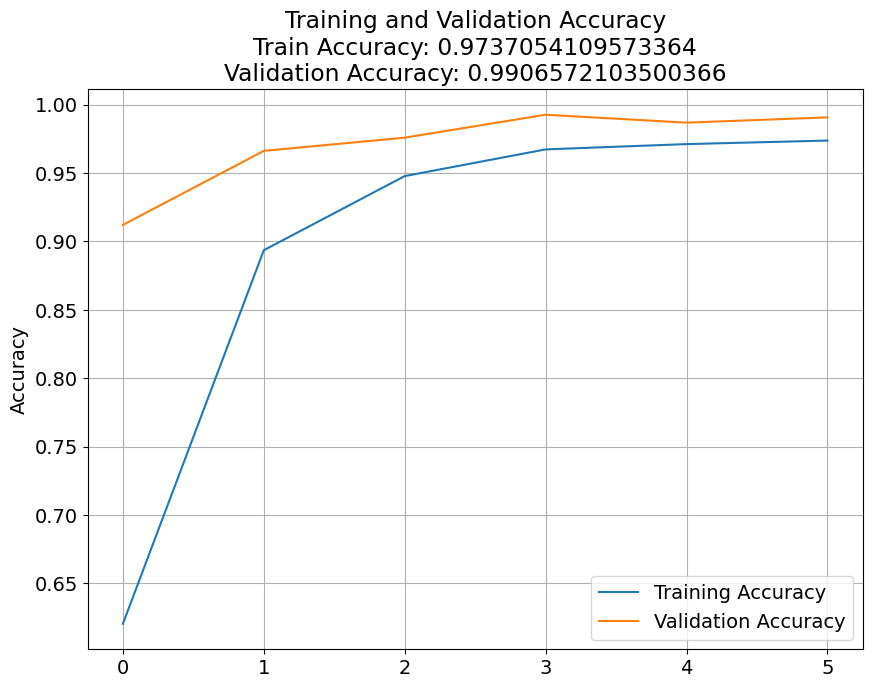

In [20]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy\nTrain Accuracy: {acc[-1]}\nValidation Accuracy: {val_acc[-1]}')

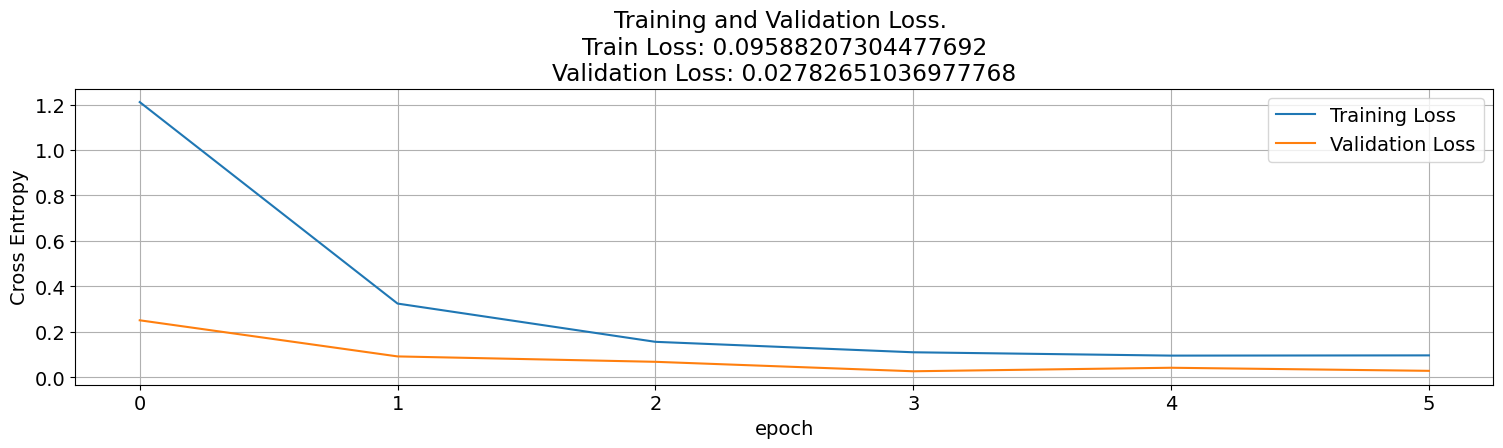

In [21]:

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Accuracy Score

In [22]:
accuracy_score = model.evaluate(validation_data)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

98/98 [==============================] - 269s 3s/step - loss: 0.0297 - accuracy: 0.9910
[0.029676971957087517, 0.9910083413124084]
Accuracy: 99.1008%
Loss:  0.029676971957087517
